## Single Decision Tree (SDT) Benchmark

H2O cloud is inicialized before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.


In [1]:
import sys
sys.path.append("h2o-py/build/main") # path to h2o build

print(sys.path)

['/Users/yuliia/work/h2o-3', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/yuliia/work/h2o-3/venv/lib/python3.9/site-packages', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages', 'h2o-py/build/main']


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2OSingleDecisionTreeEstimator
from h2o.estimators import H2ORandomForestEstimator
from sklearn.tree import DecisionTreeClassifier

versionFromGradle='3.37.0',projectVersion='3.37.0.99999',branch='yuliia-PUBDEV-8691-sdt',lastCommitHash='17fad68e6340150a13593f2295acd4748b74e522',gitDescribe='jenkins-master-5784-62-g17fad68e63-dirty',compiledOn='2022-12-12 19:02:46',compiledBy='yuliia'


In [10]:
# Notebook parameters
attempt_per_thread = 1 # number of runs of the algorithm in the thread # todo - change to 5
max_depth = 5 
threds = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
DATA_PATH = "/Users/yuliia/work/h2o-3/benchmark_data/"


In [11]:
def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    h2o.connect()
    hf = h2o.H2OFrame(data)
    start = time.time()
    SDT_h2o = H2OSingleDecisionTreeEstimator(model_id = "single_decision_tree.hex", max_depth=max_depth)
    SDT_h2o.train(training_frame = hf, y='label')
    end = time.time()
    sdt_time = end - start
    print(f"SDT Time: {sdt_time}s")
    start = time.time()
    DRF_h2o = H2ORandomForestEstimator(model_id = "random_forest.hex", ntrees = 1, max_depth = max_depth, 
                                       sample_rate=1, score_tree_interval=2)
    hf['label'].asfactor()
    DRF_h2o.train(training_frame = hf, y='label')
    end = time.time()
    drf_time = end - start
    print(f"DRF Time: {drf_time}s")
    if start_cluster:
        h2o.cluster().shutdown()
        time.sleep(10)
    return sdt_time, drf_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_sdt = []
    all_times_num_drf = []
    for nthreads in threds:
        times_sdt = []
        times_drf = []
        for i in range(attempt_per_thread):
            sdt_time, drf_time = train_models(nthreads, data, start_cluster)
            times_sdt.append(sdt_time)
            times_drf.append(drf_time)
        print(f"SDT {np.mean(times_sdt)}s")
        print(f"DRF {np.mean(times_drf)}s")
        all_times_num_sdt.append(times_sdt)
        all_times_num_drf.append(times_drf)
        all_times.append(f"thread {nthreads} - SDT {np.mean(times_sdt)}s and DRF {np.mean(times_drf)}s")

    sdt_means = dict()
    drf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - SDT = {np.mean(all_times_num_sdt[i])}, DRF = {np.mean(all_times_num_drf[i])}")
        sdt_means[nthreads] = np.mean(all_times_num_sdt[i])
        drf_means[nthreads] = np.mean(all_times_num_drf[i])
    
    return sdt_means, drf_means
        
    
def plot_result(sdt_means, drf_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in sdt_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_drf = {"x":[], "y": [], "label":[]}
    for label, coord in drf_means.items():
        data_drf["x"].append(label)
        data_drf["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-o', label="SDT", linewidth=3)
    plt.plot(data_drf['x'], data_drf['y'], '-o', label="DRF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Single Decision Tree - training benchmark\nModel: max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-perf.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage


### Big data and small dimension

In [12]:
X = pd.read_csv(DATA_PATH + "Dataset1_train.csv")
sdt_time1, drf_time1 = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp385wdamz
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp385wdamz/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp385wdamz/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_yuliia_q7n8yb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_yuliia_q7n8yb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |

/Users/yuliia/work/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.370826005935669s
drf Model Build progress: |

/Users/yuliia/work/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.453528642654419s
SDT 2.370826005935669s
DRF 2.453528642654419s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpyr6wmp1_
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpyr6wmp1_/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpyr6wmp1_/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_yuliia_h4mtac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_yuliia_h4mtac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.3516581058502197s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.675781011581421s
SDT 2.3516581058502197s
DRF 2.675781011581421s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpa8o5qh4k
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpa8o5qh4k/h2o_yuliia_started_from_python.out
  JVM std

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_yuliia_as6fdj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_yuliia_as6fdj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.432426929473877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.357647180557251s
SDT 2.432426929473877s
DRF 2.357647180557251s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp197j_pvv
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp197j_pvv/h2o_yuliia_started_from_python.out
  JVM stder

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_yuliia_xrmzaw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_yuliia_xrmzaw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 1.9601809978485107s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.227721929550171s
SDT 1.9601809978485107s
DRF 2.227721929550171s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphggq4etk
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphggq4etk/h2o_yuliia_started_from_python.out
  JVM std

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_yuliia_ornix1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_yuliia_ornix1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.0488579273223877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.1873619556427s
SDT 2.0488579273223877s
DRF 2.1873619556427s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmppz9cst_d
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmppz9cst_d/h2o_yuliia_started_from_python.out
  JVM stderr:

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_yuliia_hu75p6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_yuliia_hu75p6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.7655580043792725s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.199418783187866s
SDT 2.7655580043792725s
DRF 2.199418783187866s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp0r5gd752
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp0r5gd752/h2o_yuliia_started_from_python.out
  JVM std

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_yuliia_lr78vw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_yuliia_lr78vw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.620300054550171s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.807096004486084s
SDT 2.620300054550171s
DRF 1.807096004486084s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp4ezpeh1t
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp4ezpeh1t/h2o_yuliia_started_from_python.out
  JVM stder

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_yuliia_jrzn6i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_yuliia_jrzn6i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.2652480602264404s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.1416759490966797s
SDT 2.2652480602264404s
DRF 2.1416759490966797s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphqjap_r9
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmphqjap_r9/h2o_yuliia_started_from_python.out
  JVM s

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_yuliia_3kgvsy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_yuliia_3kgvsy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.552666187286377s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 2.542618989944458s
SDT 2.552666187286377s
DRF 2.542618989944458s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp9lfbiytm
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmp9lfbiytm/h2o_yuliia_started_from_python.out
  JVM stder

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_yuliia_1u1el8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_yuliia_1u1el8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 2.58406400680542s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.7541568279266357s
SDT 2.58406400680542s
DRF 1.7541568279266357s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpc2ha_9ow
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpc2ha_9ow/h2o_yuliia_started_from_python.out
  JVM stder

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_yuliia_em1x4x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_yuliia_em1x4x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 3.6698498725891113s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.7029309272766113s
SDT 3.6698498725891113s
DRF 1.7029309272766113s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4.1" 2022-08-12 LTS; OpenJDK Runtime Environment Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.4.9.1 (build 17.0.4.1+9-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/work/h2o-3/build/h2o.jar
  Ice root: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpq1c74bn7
  JVM stdout: /var/folders/g0/z3yr0fjx3qqbmhvs9jhqsq_r0000gn/T/tmpq1c74bn7/h2o_yuliia_started_from_python.out
  JVM s

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_yuliia_0u8in5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,5 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_yuliia_0u8in5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 6.155847072601318s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.2521188259124756s
SDT 6.155847072601318s
DRF 1.2521188259124756s
12 - SDT = 2.370826005935669, DRF = 2.453528642654419
11 - SDT = 2.3516581058502197, DRF = 2.675781011581421
10 - SDT = 2.432426929473877, DRF = 2.357647180557251
9 - SDT = 1.9601809978485107, DRF = 2.227721929550171
8 - SDT = 2.0488579273223877, DRF = 2.1873619556427
7 - SDT = 2.7655580043792725, DRF = 2.199418783187866
6 - SDT = 2.620300054550171, DRF = 1.807096004486084
5 - SDT = 2.2652480602264404, DRF = 2.1416759490966797
4 - SDT = 2.552666187286377, DRF = 2.542618989944458
3 - SDT = 2.58406400680542, DRF = 1.7541568279266357
2 - SDT = 3.6698498725891113, DRF = 1.7029309272766113
1 - SDT = 6.15584

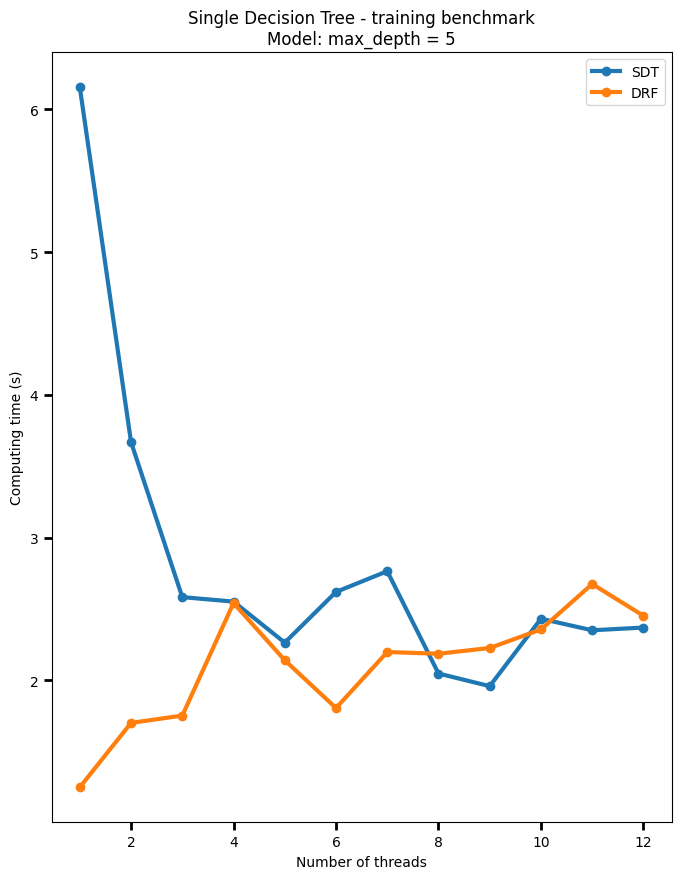

In [13]:
plot_result(sdt_time1, drf_time1)

###### Big data and big dimension

In [7]:
X = pd.read_csv(DATA_PATH + "HIGGS_train_limited1.csv")
sdt_time2, drf_time2 = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.3" 2022-04-19 LTS; OpenJDK Runtime Environment Corretto-17.0.3.6.1 (build 17.0.3+6-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.3.6.1 (build 17.0.3+6-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/diplomka/h2o-3/build/h2o.jar
  Ice root: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp352o8k1i
  JVM stdout: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp352o8k1i/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp352o8k1i/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,2 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_yuliia_2vht8r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |

/Users/yuliia/diplomka/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
SDT Time: 3.012586832046509s
drf Model Build progress: |

/Users/yuliia/diplomka/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
DRF Time: 7.577459335327148s
H2O session _sid_9ccb closed.
SDT 3.012586832046509s
DRF 7.577459335327148s
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 35 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,2 hours and 27 minutes
H2O_cluster_name:,yuliia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.518 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 1.0623259544372559s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 4.78842306137085s


H2OResponseError: Server error water.exceptions.H2ONotFoundArgumentException:
  Error: Resource /flow/index.html not found
  Request: GET /


In [39]:
plot_result(sdt_time2, drf_time2)

NameError: name 'sdt_time2' is not defined

## Evaluation Stage

In [ ]:
def run_predict(SDT_model, DRF_model, test):
    start = time.time()
    SDT_model.predict(test)
    end = time.time()
    sdt_time = end - start
    print(f"SDT Time: {sdt_time}s")
    start = time.time()
    DRF_model.predict(test)
    end = time.time()
    drf_time = end - start
    print(f"DRF Time: {drf_time}s")    
    return sdt_time, drf_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_sdt = []
    all_times_num_drf = []
    for nthreads in threds:
        times_sdt = []
        times_drf = []
        h2o.init(nthreads=nthreads)     
        train = h2o.H2OFrame(train_data)    
        test = h2o.H2OFrame(test_data)
        SDT_model = H2OSingleDecisionTreeEstimator(model_id = "single_decision_tree.hex", max_depth=max_depth)
        SDT_model.train(training_frame = train, y='label')
        DRF_model = H2ORandomForestEstimator(model_id="random_forest.hex", ntrees=1, max_depth=max_depth,
                                             sample_rate=1, score_tree_interval=2)
        train['label'].asfactor()
        DRF_model.train(training_frame = train, y='label')
        for i in range(attempt_per_thread):
            sdt_time, drf_time = run_predict(SDT_model, DRF_model, test)
            times_SDT.append(SDT_time)
            times_DRF.append(DRF_time)
        h2o.cluster().shutdown()
        print(f"SDT {np.mean(times_sdt)}s")
        print(f"DRF {np.mean(times_drf)}s")
        all_times_num_sdt.append(times_sdt)
        all_times_num_drf.append(times_drf)
        all_times.append(f"thread {nthreads} - SDT {np.mean(times_sdt)}s and DRF {np.mean(times_drf)}s")
        
        
    sdt_means = dict()
    drf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - SDT = {np.mean(all_times_num_sdt[i])}, DRF = {np.mean(all_times_num_drf[i])}")
        sdt_means[nthreads] = np.mean(all_times_num_sdt[i])
        drf_means[nthreads] = np.mean(all_times_num_drf[i])

    return sdt_means, drf_means 

def plot_predict(SDT_means, DRF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in SDT_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_drf = {"x":[], "y": [], "label":[]}
    for label, coord in DRF_means.items():
        data_drf["x"].append(label)
        data_drf["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="SDT", linewidth=3)
    plt.plot(data_drf['x'], data_drf['y'], '-', label="DRF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Single Decision Tree - evaluation benchmark\nModel: max_depth = {max_depth}")
    plt.savefig(f"h2o-eval-perf.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters
X_train = pd.read_csv("smalldata/yuliia/HIGGS_train_limited1.csv")
X_test = pd.read_csv("smalldata/yuliia/HIGGS_test_limited1.csv")
sdt_time3, drf_time3 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(sdt_time3, drf_time3)